# Tutorial 6: Improving Learning

In this tutorial, that concludes this first series of tutorials on the Halite challenge, we will finally look into the issues of learning this complex taks and propose a method to improve drastically the performances of our agent.


## Inefficient collection of halite

The training so far has been decent but not satisfactory at all. The evidence of that is that the reward function is not monotonic in the number of epochs, hence a sub-optimal strategy has been adopted.
Before saying anything else, let's have another look at some of the results we obtained.

### Training metrics for halite thresholds = {10,100,1000} and 200 epochs of 10 batches

In this first case we can see that a random agent (epoch 1, without knowing the Q-values and with $\epsilon = 0.5$)
has a better performance than the trained model. At the same time we can see that the passages through the shipyard at first they increase and then they saturate between 45 and 60. With an average reward of 6000+ this makes roughly more than 100 of halite deposited for each passage. This is comprehensible since the ship cannot distinguish between 101 and 1000 of cargo, hence every time it goes over 100 of cargo it has learned to go back to the shipyard.

<img src="Support_material/halite_10_100_1000_10batches.png" >



### Training metrics for halite thresholds = {100,500,1000} and 200 epochs of 10 batches

This was the most promising agent, since at first had learned to deposit on average around 8000 of halite in 40 passages, hence 200 of cargo for each passage. This is a strange value, because if we assume for semplicity the cargo to be either equal to 100 or to 500, it means that 25% of the times was depositing 500 of halite and the other 75% of the times 100 of halite. In other words it was a peak, but not a stable configuration. At the final level we have on average roughly 42 of cargo for each passage, meaning that it was always in the lowest state of cargo. This is of course a very bad thing.

<img src="Support_material/halite_100_500_1000_10batches.png" >



### Training metrics for halite thresholds = {100,500,1000} and 200 epochs of 30 batches

Retraining with the same halite levels but with more batches for epoch has completely changed the behaviour. We would be tempted to say that it reached a stable equilibrium (even if not optimal, 7000 halite, 45 passages, 155 halite for passage), but just before the end the strategy changed again, for the worse.
<img src="Support_material/halite_100_500_1000_30batches.png" >

## Observations 

First of all it has become clear that the reward metric at the moment is useless (the amount of halite collected is much more intuitive as a metric) and could be replaced by the average cargo deposited per passage.

Secondly, we can clearly see that choosing the intervals of quantization of the halite (both for the map's cells and the cargo) influences a lot the result. 

## Problems

It seems that there are two problems at work here: one is that somehow for the ship is convenient to go back to the shipyard even with the smallest amount of halite and the other one is that this problem is coupled with the fact that the quantization levels of the halite prevent the ship from exploiting efficiently its halite levels.

For sure we could try ad infinitum at designing the halite levels in order to get better results, but this would increase the performance without solving some core issues of the learning. Instead we can tackle these issues in a simple and elegant way.

## Ideas

1. Give a more negative baseline for the reward when depositing halite, in order to discourage too many loops (better few but of quality).
2. Encode the halite carried with more levels, in order to reduce the stochasticity induced by the quantization of the halite.

The first improvement is gratis in terms of algorithmic complexity, whereas the second one if we increase of just one level the cargo quantization we get an increase of $\frac{4}{3}= 133\%$ of the state compexity, that is completely managable.

In [16]:
#import modules and libraries
import sys
sys.path.insert(0, "../Environment/")
sys.path.insert(0, "../Modules/")
import halite_env as Env
import encode as cod
import ship 

import numpy as np
import matplotlib.pyplot as plt

Here we introduce directly the thresholds instead of just the number of levels of quantization and generalize the whole algorithm so that we can vary the thresholds both in quantity and values. Also we decoupled the threshold for the halite in the cells of the map and those for the halite carried. The idea is that the space complexity scales linearly with the quantization levels of the halite carried, whereas if we were to change all the quantiazion levels together it would have been a polynomial dependence of the 6-th order (e.g. from 3 to 4 levels would have made the task the 562% more complex instead of the 133% with just the increase in the cargo levels).

In [5]:
#@@@@@@@@@@@@@@@@@@@@@@
# Environment variables
#@@@@@@@@@@@@@@@@@@@@@@
NUM_PLAYERS = 1
MAP_SIZE = 7 # 7 x 7 map
TOT_TURNS = 400 # number of turns for each episode

#@@@@@@@@@@@@@@@@
# State variables
#@@@@@@@@@@@@@@@@
MAP_H_THRESHOLDS = np.array([100,500,1000]) # 3 halite levels for the halite in the map's cells
H_LEV = len(MAP_H_THRESHOLDS)
CARGO_THRESHOLDS = np.array([100,500,800,1000]) # 4 halite levels for the halite carried (finer granularity)
CARGO_LEV = len(CARGO_THRESHOLDS)
N_CELLS = MAP_SIZE**2 # number of cells in a square map
N_STATES = N_CELLS*(H_LEV**5)*CARGO_LEV*4
N_ACTIONS = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
print("Total number of states to be experienced: ", N_STATES)

#@@@@@@@@@@@@@@@@@@@@
# Learning parameters
#@@@@@@@@@@@@@@@@@@@@
N_BATCH = 70 # number of episodes in an epoch
MAX_EPOCHS = 200 # max number of epochs played before stopping
DISCOUNT_FACTOR = 1 - 1/TOT_TURNS #train ships as if each turn has a probability of 1/tot_turns of ending the game 
R0 = -0.01 # penalty given each turn to the ship if it doesn't deposit halite in the shipyard ("cost of the time")
R1 = R0*50 # penalty given to the ship when deposits halite ("cost of a loop")
LEARNING_RATE = 0.1
EPS_START = 0.5

Total number of states to be experienced:  190512


In [6]:
# convert all the parameters to dictionaries
env_dict = dict(NUM_PLAYERS = NUM_PLAYERS , 
                TOT_TURNS = TOT_TURNS)

state_dict = dict(MAP_SIZE = MAP_SIZE,  
                  MAP_H_THRESHOLDS = MAP_H_THRESHOLDS, 
                  CARGO_THRESHOLDS = CARGO_THRESHOLDS,
                  N_ACTIONS = N_ACTIONS)

learning_dict = dict(LEARNING_RATE = LEARNING_RATE, 
                     DISCOUNT_FACTOR = DISCOUNT_FACTOR , 
                     eps = EPS_START, 
                     R0 = R0, R1 = R1)

In [7]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained

This is the modified function accounting for the new thresholds and the new penalty term. We now call R0 the penalty given to the agent each turn and R1 the penalty for depositing the halite.

In [8]:
def play_episode_v1(q_values, eps, NUM_PLAYERS, MAP_SIZE, TOT_TURNS, N_ACTIONS, MAP_H_THRESHOLDS, CARGO_THRESHOLDS,
                 R0, R1, LEARNING_RATE, DISCOUNT_FACTOR, verbose = False, debug = True):
    """
    Trains the agent by playing one episode of halite.
    
    Parameters
    ----------
    q_values         : numpy array 
        Contains the Q-values
    eps              : float 
        Represents a probability, must be in [0,1], controls the probability of exploring instead of exploting
    NUM_PLAYERS      : int
    MAP_SIZE         : int
    TOT_TURNS        : int
    N_ACTIONS        : int
    H_LEV            : int
    STD_REWARD       : float
        Baseline reward given to the agent when does not deposit halite to the shipyard
    LEARNING_RATE    : float
    DISCOUNT_FACTOR  : float
        Must be greater than 0 but smaller than 1. Suggested 1-1/TOT_TURNS or 1
    verbose          : bool
        Prints halite of the player at each turn of the game
        
    Returns
    -------
    q_values         : numpy array 
        Updated Q-values
    reward           : float
        Reward obtained in this episode. 
    collected_halite : float
        Halite collected by the agent.
    passages         : int
        Number of passages of the ship through the shipyard.
    """
    # define some derived constants
    H_LEV = len(MAP_H_THRESHOLDS)+1
    CARGO_LEV = len(CARGO_THRESHOLDS)+1
    
    verbose_print = print if verbose else lambda *args, **kwargs : None # define verbose printing function
    
    env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = TOT_TURNS) # init environment
    steps = 0
    reward = 0 # cumulative reward of the episode
    passages = 0 # number of times the ship passes through the shipyard
    
    # first mandatory step
    steps = steps + 1
    verbose_print("\nStep number %d:"%steps)
    action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
    shipyard_action = True # initially always choose to create a ship
    # returns the matricial state, the array of players halite and a flag that is true if it's the final turn
    state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
    current_halite = players_halite[0][0]
    s_enc = cod.encode_state_v1(state, MAP_H_THRESHOLDS, CARGO_THRESHOLDS, map_size = MAP_SIZE, debug = debug)

    while True:
        steps = steps + 1
        verbose_print("\nStep number %d:"%steps)
        verbose_print("Current halite: ", current_halite)
        a_enc = ship.e_greedy_policy(s_enc, q_values, eps = eps)
        a_mat = cod.scalar_to_matrix_action(a_enc, state, map_size = MAP_SIZE) #convert the action in matricial form

        # submit the action and get the new state
        state, players_halite, finish, _ = env.step(a_mat, makeship = False) 

        new_halite = players_halite[0][0]

        # compute the 1-ship reward as the halite increment of the player divided by the max halite 
        # plus a standard negative reward 
        #---------------------------------------------------------------------------------------------------------
        if new_halite == current_halite:
            r =  R0
        else:
            r = (new_halite - current_halite)/1000 + R1 # this is the change in the code
        #---------------------------------------------------------------------------------------------------------
        sp_enc = cod.encode_state_v1(state, MAP_H_THRESHOLDS, CARGO_THRESHOLDS, map_size = MAP_SIZE, debug = debug)
        reward += r # cumulative reward of the episode

        # adds 1 to passages if the current position of the ship coincides with that of the shipyard
        # whereas the previous position didn't
        s_dec = cod.decode3D(s_enc, L1 = MAP_SIZE**2, L2 = CARGO_LEV*H_LEV**5, L3 = N_ACTIONS-1)
        sp_dec = cod.decode3D(sp_enc, L1 = MAP_SIZE**2, L2 = CARGO_LEV*H_LEV**5, L3 = N_ACTIONS-1)
        shipy_pos = (MAP_SIZE**2-1)/2 #shipyard is at the center of the map
        if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
            passages = passages +1
                
        a_temp_enc = ship.greedy_policy(sp_enc, q_values) # simulate the best action in the new state (before update)

        # update Q-values
        q_values = ship.update_q_v3(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, 
                                    alpha = LEARNING_RATE, gamma = DISCOUNT_FACTOR, map_size = MAP_SIZE, 
                                    h_lev = H_LEV, cargo_lev = CARGO_LEV, n_actions = N_ACTIONS)

        # update states and halite
        s_enc = sp_enc
        current_halite = new_halite

        if (finish == True) or (steps >= 400):
            verbose_print("\nEnd episode.")
            break
    collected_halite = current_halite - 4000
    return q_values, reward, collected_halite, passages

<IPython.core.display.Javascript object>


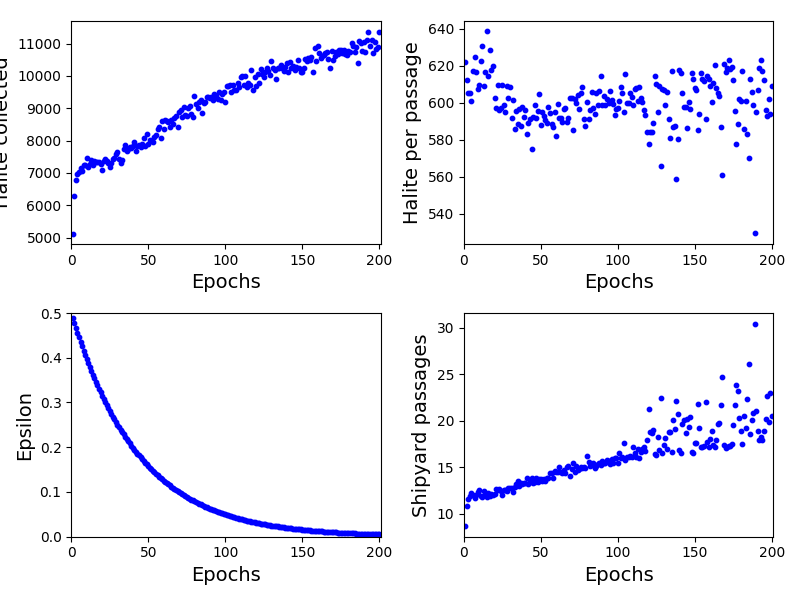

Hey, I think you've had enough! Let's stop here.


In [64]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained
reward_score = np.zeros(MAX_EPOCHS)
halite_score = np.zeros(MAX_EPOCHS)
shipy_pass = np.zeros(MAX_EPOCHS)
epochs = 0
eps = EPS_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/MAX_EPOCHS), np.arange(0,MAX_EPOCHS+1))))


# visualize online the results
%matplotlib notebook
fig = plt.figure(figsize = (8,6))
plt.ion()

ax1 = fig.add_subplot(221)
ax1.set_xlim(0,MAX_EPOCHS+1)
#ax1.set_ylim(0,9000)
ax1.set_xlabel("Epochs", fontsize = 14)
ax1.set_ylabel("Halite collected", fontsize = 14)

ax2 = fig.add_subplot(222)
ax2.set_xlim(0,MAX_EPOCHS+1)
#ax2.set_ylim(-4,5)
ax2.set_xlabel("Epochs", fontsize = 14)
ax2.set_ylabel("Halite per passage", fontsize = 14)


ax3 = fig.add_subplot(223)
ax3.set_xlim(0,MAX_EPOCHS+1)
ax3.set_ylim(0,0.5)
ax3.set_xlabel("Epochs", fontsize = 14)
ax3.set_ylabel("Epsilon", fontsize = 14)


ax4 = fig.add_subplot(224)
ax4.set_xlim(0,MAX_EPOCHS+1)
ax4.set_xlabel("Epochs", fontsize = 14)
ax4.set_ylabel("Shipyard passages", fontsize = 14)

plt.tight_layout()
fig.show()
fig.canvas.draw()

from tqdm import tnrange, trange

for k in tnrange(MAX_EPOCHS, desc='1st loop', leave=True):
    #@@@@@@@@@@@@@@@@@@@@@@
    # here starts an epoch
    #@@@@@@@@@@@@@@@@@@@@@@
    epochs = epochs + 1
    reward_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    halite_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    shipy_pass_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    eps = epsilons[epochs]
    # update the dictionary at each epoch with the new epsilon
    learning_dict = dict(LEARNING_RATE = LEARNING_RATE, 
                     DISCOUNT_FACTOR = DISCOUNT_FACTOR , 
                     eps = eps, 
                     R0 = R0, R1 = R1)
    
    for i in tnrange(N_BATCH, desc='2nd loop', leave=False):
        # here starts an episode
        q_values, reward, collected_halite, passages = ship.play_episode_v1(q_values, **env_dict, **state_dict, **learning_dict)
        if passages > 0:
            reward_progress[i] = collected_halite/passages
        else:
            reward_progress[i] = 0
        halite_progress[i] = collected_halite
        shipy_pass_progress[i] = passages

        #break # play just 1 episode

    #break # play just 1 epoch

    reward_score[epochs-1] = reward_progress.mean()
    halite_score[epochs-1] = halite_progress.mean()
    shipy_pass[epochs-1] = shipy_pass_progress.mean()
    
    ax1.scatter(epochs, halite_score[epochs-1], s = 10, color='blue')
    ax2.scatter(epochs, reward_score[epochs-1], s = 10,color='blue')
    ax3.scatter(epochs, epsilons[epochs], s = 10, color='blue')
    ax4.scatter(epochs, shipy_pass[epochs-1], s = 10, color='blue')
    fig.canvas.draw()

    if epochs >= MAX_EPOCHS:
        print("Hey, I think you've had enough! Let's stop here.")
        break

In [69]:
np.save("Q_values/Q_values_new_method.npy", q_values)

## Visualizing the new result

As we have done in the previous tutorial, after the training we can see with our own eyes how the agent is performing.

In [10]:
q_values = np.load("Q_values/Q_values_new_method.npy")

In [11]:
# some functions to represent in RGB the halite levels of the map and the ship

def color_sea(map_halite):
    #color1 = np.array([32,124,157])
    sea_colors = np.zeros((1001,3))
    for i in range(1001):
        sea_colors[i] = [32,20+i/10,50+2*i/10]
    N = len(map_halite.flatten())
    rgb_map = np.zeros((N,3))
    flatten_map = map_halite.flatten()
    for i in range(N):
        rgb_map[i] = sea_colors[int(flatten_map[i])]
    return rgb_map.reshape((map_halite.shape)+(3,))/255

def color_ship(cargo):
    #color2 = np.array([255,203,119])
    ship_colors = np.zeros((1001,3))
    for i in range(1001):
        ship_colors[i] = [(120+2*i/10)*250/320,(70+2*i/10)*200/270,(90+i/10)*120/210]
    return ship_colors[int(cargo)]/255    

def decision_map(q_s, x, y, rgb_map, map_size = 7, alpha=0.5):
    
    def Q_to_color(q_array):
        x = (q_array-q_array.min()+ 1e-5)/(q_array.max() - q_array.min() + 1e-5)
        color = np.array([[225*(1-xi),225*xi,25] for xi in x])/255
        return color
    
    pos_dict = {0:(0,0), 1:(1,0), 2:(-1,0), 3:(0,1), 4:(0,-1)}
    q_colors = Q_to_color(q_s)
    pos_dec = (x,y)
    for i in range(5):
        xi = (pos_dec[0]+pos_dict[i][0])%map_size
        yi = (pos_dec[1]+pos_dict[i][1])%map_size
        rgb_map[xi,yi] = alpha*q_colors[i]+(1-alpha)*rgb_map[xi,yi]
    return rgb_map

<IPython.core.display.Javascript object>


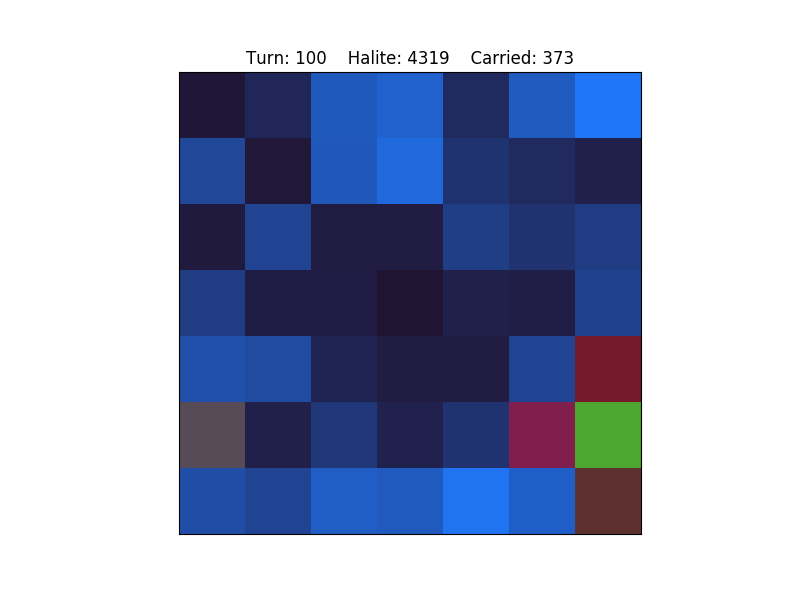

In [13]:
save = True
debug = False
verbose = False
eps = 0.05

%matplotlib notebook

fig = plt.figure(figsize = (8,6))

# define some derived constants
H_LEV = len(MAP_H_THRESHOLDS)
CARGO_LEV = len(CARGO_THRESHOLDS)

verbose_print = print if verbose else lambda *args, **kwargs : None # define verbose printing function

env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = 100) # init environment
steps = 0
reward = 0 # cumulative reward of the episode
passages = 0 # number of times the ship passes through the shipyard

# first mandatory step
steps = steps + 1
verbose_print("\nStep number %d:"%steps)
action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
shipyard_action = True # initially always choose to create a ship
# returns the matricial state, the array of players halite and a flag that is true if it's the final turn
state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
current_halite = players_halite[0][0]
#----------------------------------------------------------
rgb_map = color_sea(state[:,:,0]) # get rgb map of blue tonalities
plt.imshow(rgb_map) # show map
plt.title("Turn: %d    Halite: %d"%(steps,current_halite))
plt.yticks([])
plt.xticks([])
fig.show()
fig.canvas.draw() # update the figure
#time.sleep(0.2) #uncomment to slow down for visualization purposes
if save:
    plt.savefig('.raw_gif/turn%.3d.png'%steps)
#-----------------------------------------------------------
s_enc = cod.encode_state_v1(state, MAP_H_THRESHOLDS, CARGO_THRESHOLDS, map_size = MAP_SIZE, debug = debug)


while True:
    steps = steps + 1
    verbose_print("\nStep number %d:"%steps)
    verbose_print("Current halite: ", current_halite)
    a_enc = ship.e_greedy_policy(s_enc, q_values, eps = eps)
    a_mat = cod.scalar_to_matrix_action(a_enc, state, map_size = MAP_SIZE) #convert the action in matricial form
    s_dec = cod.decode3D(s_enc, L1 = MAP_SIZE**2, L2 = CARGO_LEV*H_LEV**5, L3 = N_ACTIONS-1)
    x,y = cod.decode(s_dec[0], L=MAP_SIZE) # position of the ship, used in rendering
    ship_cargo = state[x,y,2] # halite in the ship, used in rendering
    # submit the action and get the new state
    state, players_halite, finish, _ = env.step(a_mat, makeship = False) 

    new_halite = players_halite[0][0]

    # compute the 1-ship reward as the halite increment of the player divided by the max halite 
    # plus a standard negative reward 
    #---------------------------------------------------------------------------------------------------------
    if new_halite == current_halite:
        r =  R0
    else:
        r = (new_halite - current_halite)/1000 + R1 # this is the change in the code
    #---------------------------------------------------------------------------------------------------------
    sp_enc = cod.encode_state_v1(state, MAP_H_THRESHOLDS, CARGO_THRESHOLDS, map_size = MAP_SIZE, debug = debug)
    reward += r # cumulative reward of the episode

    # adds 1 to passages if the current position of the ship coincides with that of the shipyard
    # whereas the previous position didn't
    
    sp_dec = cod.decode3D(sp_enc, L1 = MAP_SIZE**2, L2 = CARGO_LEV*H_LEV**5, L3 = N_ACTIONS-1)
    shipy_pos = (MAP_SIZE**2-1)/2 #shipyard is at the center of the map
    if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
        passages = passages +1

    a_temp_enc = ship.greedy_policy(sp_enc, q_values) # simulate the best action in the new state (before update)

    #----------------------------------------------------------
    rgb_map = color_sea(state[:,:,0]) # get rgb map of blue tonalities
    rgb_map[x ,y,:] = color_ship(ship_cargo) # superimpose the ship pixel with a yellow tonality
    plt.cla() # clear current axis from previous drawings -> prevents matplotlib from slowing down
    plt.imshow(rgb_map)
    plt.title("Turn: %d    Halite: %d    Carried: %d"%(steps,current_halite-4000,ship_cargo))
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    #time.sleep(2) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif/turn%.3d.png'%(steps*2))
    # shows Q-values projected on the cells adjacent to the ship
    rgb_map = decision_map(q_values[s_enc], x, y, rgb_map, MAP_SIZE) 
    plt.imshow(rgb_map)
    #move_dict = {0:'C',1:'S',2:'N',3:'E',4:'W'}
    plt.title("Turn: %d    Halite: %d    Carried: %d"%(steps, current_halite-4000, ship_cargo))
    #+"Next action: "+move_dict[a_enc]) # to print also what the next move will be
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    #time.sleep(2) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif/turn%.3d.png'%(steps*2+1))
    #-----------------------------------------------------------
    
    # update Q-values
    q_values = ship.update_q_v3(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, 
                                alpha = LEARNING_RATE, gamma = DISCOUNT_FACTOR, map_size = MAP_SIZE, 
                                h_lev = H_LEV, cargo_lev = CARGO_LEV, n_actions = N_ACTIONS)

    # update states and halite
    s_enc = sp_enc
    current_halite = new_halite

    if (finish == True) or (steps >= 400):
        verbose_print("\nEnd episode.")
        break

In [14]:
import os
filenames = os.listdir('.raw_gif') # get the names of all the files in .raw_gif directory
filenames.sort() # sort them by name (i.e. by turn in our specific case)

In [15]:
# ! pip install imageio
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('.raw_gif/'+filename))
imageio.mimsave('Support_material/play_episode.gif', images, duration=0.75) # make gif

<img src='Support_material/play_episode.gif'>

## Final remarks and future developments

As you can see, this time the agent has learned to be patient enough to wait until having a cargo of 800 before returning back to the shipyard. 

We think that, even though with some tricks the performances of the agent could be boosted, the task is qualitatively solved for a single agent. 

Some future developments are:
1. Scaling to multi-agent system (we will probably reduce the number of turns in an episode in order not to finish the halite and maybe also increase a bit the map size to have more space of maneuver).
2. Using DeepQ-learning to go beyond tabular methods both in generality and in performances. The most annoying thing of tabular methods is the fact that they do not really understand the space of the game and they just encode it categorically; this is of course the greatest limitation of this method.
3. Find some efficient way to use the symmetry of the problem at our advantage. Potentially we could have 8x of the experience with the same number of epochs and this could also help the algorithm to be much more stable.


If you've come this far in the tutorials we sincerely thank you for the interest. Please write to us for any comments or informations (you can find our emails at the beginning of the README.